## Random Sampling
Алгоритм перебалансировки наблюдений по классам

### Under sampling 

Перебалансировка удалением случайного наблюдения из больших классов до числа наблюдений соответствующих минимальному классу

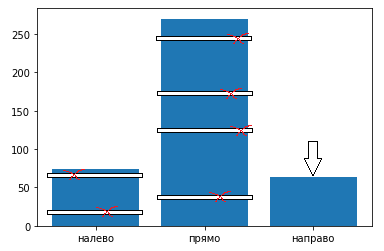

### Over sampling

Перебалансировка добавлением случайного наблюдения малым классам до числа наблюдений соответствующих максимальному классу (своеобразный Bootstrap).
    
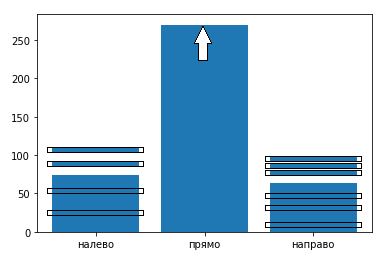

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import numpy as np
import random
import pandas as pd

## Подготовка данных - задание дисбаланса.

In [95]:
X, y = datasets.make_classification(n_classes=3, n_informative=5, n_samples=500)

indexes0 = np.where(y==0)[0]
indexes1 = np.where(y==1)[0]
indexes2 = np.where(y==2)[0]

new0 = np.random.choice(indexes0, int(len(indexes0) * 0.5), replace=False)
new1 = np.random.choice(indexes1, int(len(indexes1) * 0.75), replace=False)
new2 = indexes2

indexes = np.hstack([new0, new1, new2])

X = X[indexes,:].copy()
y = y[indexes].copy()

print("Начальный размер классов:", np.bincount(y))

clf = KNN(k=3)
cv = clf.cv(X, y, cv=5)

print("\n*** Результат скользящего контроля ***")
print("Доля верных ответов:", str(cv)[:5])

Начальный размер классов: [ 81 126 168]

*** Результат скользящего контроля ***
Доля верных ответов: 0.639


In [84]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        labels = [self.find_labels(x_test) for x_test in X_test]
        return np.array(labels)
    
    def find_labels(self, x_test):
        distances = [self.distance(x_test, x_train) for x_train in self.X_train]   
        k_nearest = np.argsort(distances)[:self.k]
        y_labels = [self.y_train[i] for i in k_nearest]
            
        return self.most_common(y_labels)
        
    def most_common(self, y_labels):
        a = tuple(set(y_labels))
        count = [y_labels.count(i) for i in a]
        return a[np.argsort(count)[-1]]
    
    def score(self, y_predicted, y_train):
        return (y_predicted == y_train).sum() / len(y_train)

    def distance(self, x_test, x_train):
        return np.sqrt(np.abs(np.sum((x_test - x_train)**2)))
    
    def cv(self, X, y, cv=5):
        y = np.reshape(y, (len(y), 1))
        data = np.concatenate((X, y), axis=1)
        np.random.shuffle(data)
        
        data = pd.DataFrame(data)
        score = []
        
        for i in range(cv):
            lenght = int(len(y) / cv)
            
            end = i * lenght + lenght
            
            if i == cv - 1: 
                end = -1
            
            X_test = data.iloc[i * lenght: end, :-1]
            X_train = data.drop(index=X_test.index).iloc[:, :-1]
            
            y_test = data.iloc[i * lenght: end, -1]
            y_train = data.drop(index=X_test.index).iloc[:, -1]
            
            clf = KNN(k=self.k)
            clf.fit(np.array(X_train), np.array(y_train))
            s_ = clf.score(clf.predict(np.array(X_test)), np.array(y_test))
            score.append(s_)
        
        return np.array(score).mean()

In [110]:
class RandomSampling(object):
    def __init__(self, X, y, method):
        self.X = X
        self.y = y
        self.method = method
    
    def resample(self):
        cnt = np.bincount(self.y)
        
        min_, max_ = min(np.bincount(y)), max(np.bincount(y))
        
        for i in np.unique(self.y):
            amount = cnt[i]
            X_c = self.X[self.y == i]
            
            if self.method == "over-sampling":
                while amount < max_:
                    ind = random.randrange(0, X_c.shape[0])
                    X_bs = np.array([X_c[ind]])
                    self.X = np.concatenate((self.X, X_bs), axis=0)
                    self.y = np.append(self.y, i)
                    amount += 1

            if self.method == "under-sampling":
                while amount > min_:
                    y_index = np.where(self.y == i)[0]
                    index = random.choice(y_index)
                    self.X = np.delete(self.X, index, axis=0)
                    self.y = np.delete(self.y, index)
                    amount -= 1

        return self.X, self.y

In [111]:
res = RandomSampling(X, y, method="under-sampling")
X_res, y_res = res.resample()

print("*** Перебалансировка классов до минимального ***")
print("Размер классов:", np.bincount(y_res))

clf = KNN(k=3)
cv = clf.cv(X_res, y_res, cv=5)

print("\n*** Результат скользящего контроля ***")
print("Доля верных ответов:", str(cv)[:5])

*** Перебалансировка классов до минимального ***
Размер классов: [81 81 81]

*** Результат скользящего контроля ***
Доля верных ответов: 0.624


In [112]:
res = RandomSampling(X, y, method="over-sampling")
X_res, y_res = res.resample()

print("*** Перебалансировка классов до максимального ***")
print("Размер классов:", np.bincount(y_res))

clf = KNN(k=3)
cv = clf.cv(X_res, y_res, cv=5)

print("\n*** Результат скользящего контроля ***")
print("Доля верных ответов:", str(cv)[:5])

*** Перебалансировка классов до максимального ***
Размер классов: [168 168 168]

*** Результат скользящего контроля ***
Доля верных ответов: 0.747
